<a href="https://colab.research.google.com/github/PhanNguyenHoangBao-ITITIU20165/Chest-X-ray-Images/blob/main/Chest_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

! unzip "chest-xray-pneumonia.zip"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  infl

In [ ]:
import os
import random
import itertools
from PIL import Image

#--------------------------------------------------------------------------------------#

import numpy as np
import pandas as pd

#--------------------------------------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#--------------------------------------------------------------------------------------#

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.applications import DenseNet121
from keras.applications import InceptionV3
from keras.applications import MobileNetV2

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--------------------------------------------------------------------------------------#

import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(f'Tensorflow Version: {tf.__version__}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.15.0
Num GPUs Available:  1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}

    folders = os.listdir(path)

    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)

        for file in files:
            filepath = os.path.join(folderpath, file)

            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    return pd.DataFrame(data)

#--------------------------------------------------------------------------------------#

def set_seed(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)

In [ ]:
train_path = '/content/chest_xray/train'
val_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'

train_df = generate_dataset(train_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
val_df = generate_dataset(val_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
test_df = generate_dataset(test_path).sample(frac = 1, random_state = 0).reset_index(drop = True)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (5216, 2): 
                                             imgpath     labels
0  /content/chest_xray/train/PNEUMONIA/person1670...  PNEUMONIA
1  /content/chest_xray/train/PNEUMONIA/person295_...  PNEUMONIA
2  /content/chest_xray/train/PNEUMONIA/person1696...  PNEUMONIA
3  /content/chest_xray/train/PNEUMONIA/person738_...  PNEUMONIA
4  /content/chest_xray/train/NORMAL/IM-0369-0001....     NORMAL

Validation Dataframe of shape (16, 2): 
                                             imgpath     labels
0  /content/chest_xray/val/NORMAL/NORMAL2-IM-1427...     NORMAL
1  /content/chest_xray/val/NORMAL/NORMAL2-IM-1431...     NORMAL
2  /content/chest_xray/val/PNEUMONIA/person1951_b...  PNEUMONIA
3  /content/chest_xray/val/PNEUMONIA/person1950_b...  PNEUMONIA
4  /content/chest_xray/val/PNEUMONIA/person1947_b...  PNEUMONIA

Testing Dataframe of shape (624, 2): 
                                             imgpath     labels
0  /content/chest_xray/test/PNEUMONIA/person90_

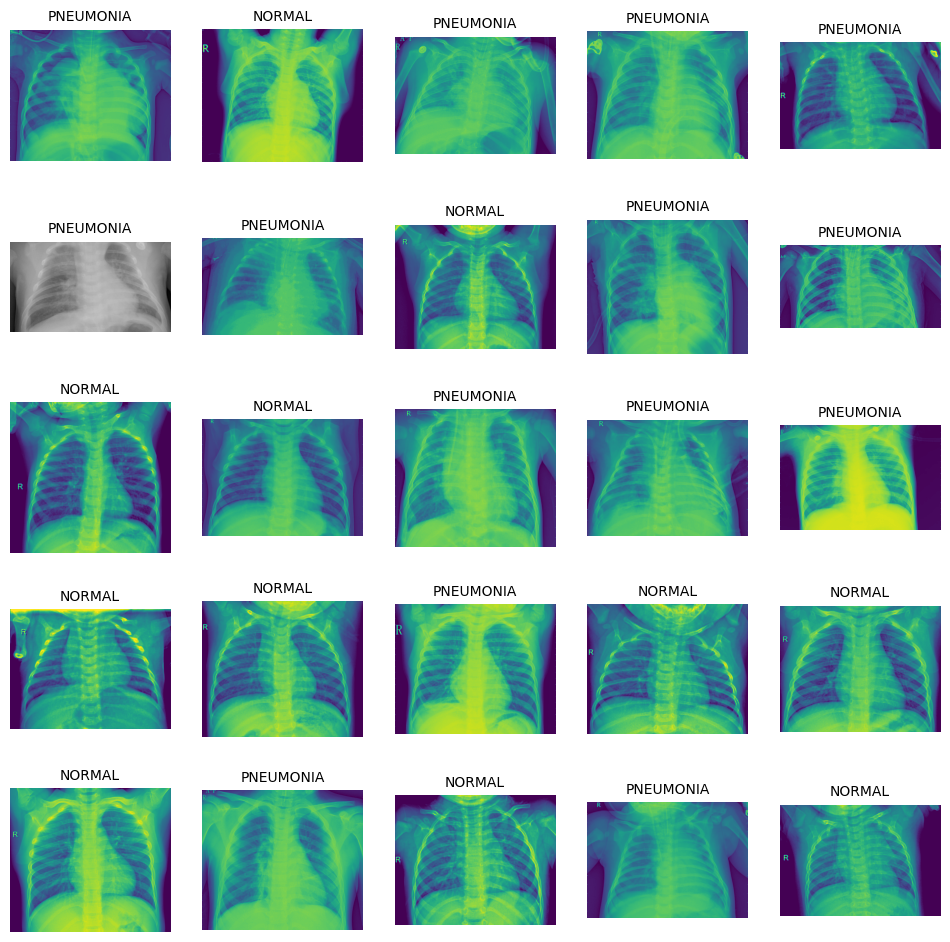

In [ ]:
rows = 5
cols = 5

dataset = pd.concat([train_df, test_df, val_df])

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

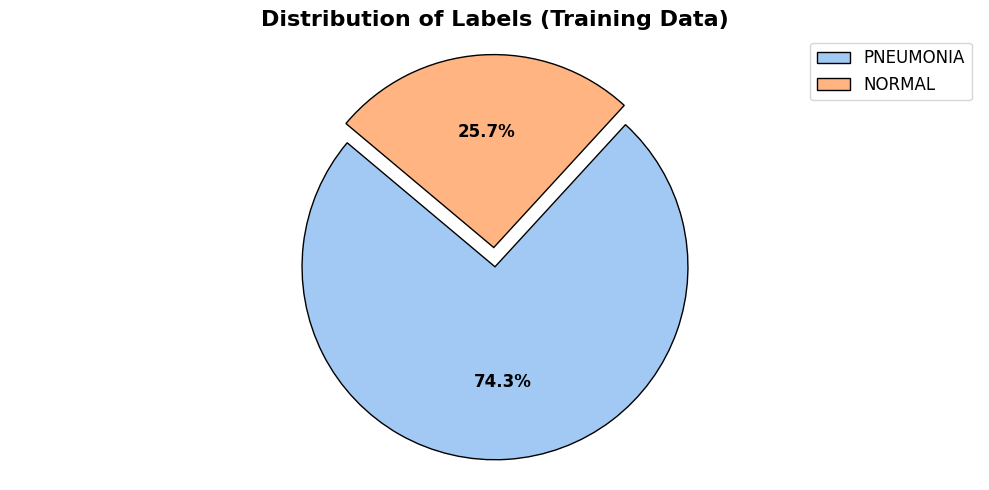

In [ ]:
dataset = train_df

fig, ax = plt.subplots(figsize = (10, 5))

labels = dataset['labels'].value_counts().index
sizes = dataset['labels'].value_counts().values
colors = sns.color_palette('pastel')

wedges, texts, autotexts = ax.pie(sizes, colors = colors,
                                  autopct = '%1.1f%%', startangle = 140,
                                  explode = (0.1, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels (Training Data)', fontsize = 16, fontweight = 'bold')
ax.axis('equal')
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [ ]:
%%time

BATCH_SIZE = 16
IMG_SHAPE = (128, 128)
SEED = 0
EPOCHS = 30

traingen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.02,
                              height_shift_range = 0.02,
                              zoom_range = 0.05,
                              horizontal_flip = True)

testgen = ImageDataGenerator(rescale = 1./255)

train_images = traingen.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels',
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                            shuffle = True, seed = SEED)

val_images = testgen.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels',
                                         class_mode = 'binary', color_mode = 'rgb',
                                         batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                         shuffle = False)

test_images = testgen.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels',
                                          class_mode = 'binary', color_mode = 'rgb',
                                          batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                          shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
CPU times: user 46.2 ms, sys: 12 ms, total: 58.2 ms
Wall time: 61.6 ms


In [ ]:
base_model = DenseNet121(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')
for layer in base_model.layers[:-10]:
    layer.trainable = False


base_model1 = VGG16(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')
for layer in base_model.layers[:-10]:
    layer.trainable = False


base_model2 = InceptionV3(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')
for layer in base_model.layers[:-10]:
    layer.trainable = False


base_model3 = MobileNetV2(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')
for layer in base_model.layers[:-10]:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model1 = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model1,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model1.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model2 = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model2,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model2.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model3 = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model3,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model3.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model.summary()
model1.summary()
model2.summary()
model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_98 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
%%time

set_seed(SEED)

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

print('DenseNet121')
history = model.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

print('VGG16')
history1 = model1.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

print('InceptionV3')
history2 = model2.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

print('MobileNetV2')
history3 = model3.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

DenseNet121
Epoch 1/30
326/326 [==============================] - 79s 217ms/step - loss: 1.0535 - accuracy: 0.9538 - val_loss: 0.8050 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/30
326/326 [==============================] - 68s 208ms/step - loss: 0.5326 - accuracy: 0.9649 - val_loss: 0.7888 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/30
326/326 [==============================] - 71s 217ms/step - loss: 0.2982 - accuracy: 0.9714 - val_loss: 0.3132 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
326/326 [==============================] - 67s 206ms/step - loss: 0.2108 - accuracy: 0.9716 - val_loss: 0.3888 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/30
326/326 [==============================] - 68s 208ms/step - loss: 0.1567 - accuracy: 0.9795 - val_loss: 0.4401 - val_accuracy: 0.8750 - lr: 2.0000e-04
Epoch 6/30
326/326 [==============================] - 67s 206ms/step - loss: 0.1334 - accuracy: 0.9835 - val_loss: 0.4146 - val_accuracy: 0.8750 - lr: 4.0000e-05
VGG16
Epoch 1/30
326/326 [======

In [ ]:
test_results = model.evaluate(test_images, verbose = 0)
test_results1 = model1.evaluate(test_images, verbose = 0)
test_results2 = model2.evaluate(test_images, verbose = 0)
test_results3 = model3.evaluate(test_images, verbose = 0)

print(f'Test Loss of DenseNet121: {test_results[0]:.5f}')
print(f'Test Accuracy of DenseNet121: {(test_results[1] * 100):.2f}%')

print(f'Test Loss of VGG16: {test_results1[0]:.5f}')
print(f'Test Accuracy of VGG16: {(test_results1[1] * 100):.2f}%')

print(f'Test Loss of InceptionV3: {test_results2[0]:.5f}')
print(f'Test Accuracy of InceptionV3: {(test_results2[1] * 100):.2f}%')

print(f'Test Loss of MobileNetV2: {test_results3[0]:.5f}')
print(f'Test Accuracy of MobileNetV2: {(test_results3[1] * 100):.2f}%')

Test Loss of DenseNet121: 0.75911
Test Accuracy of DenseNet121: 83.97%
Test Loss of VGG16: 0.46529
Test Accuracy of VGG16: 83.81%
Test Loss of InceptionV3: 0.90419
Test Accuracy of InceptionV3: 84.46%
Test Loss of MobileNetV2: 0.27838
Test Accuracy of MobileNetV2: 90.54%


In [ ]:
class_labels = list(train_images.class_indices.keys())

test_classes = test_images.classes
predicted_classes = np.round(model.predict(test_images, verbose = 0))

print(f'Classification Report (Test) for DenseNet121 --> \n\n' + \
f'{classification_report(test_classes, predicted_classes, target_names = class_labels)}')

predicted_classes1 = np.round(model1.predict(test_images, verbose = 0))

print(f'Classification Report (Test) for VGG16 --> \n\n' + \
f'{classification_report(test_classes, predicted_classes1, target_names = class_labels)}')

predicted_classes2 = np.round(model2.predict(test_images, verbose = 0))

print(f'Classification Report (Test) for InceptionV3 --> \n\n' + \
f'{classification_report(test_classes, predicted_classes2, target_names = class_labels)}')

predicted_classes3 = np.round(model3.predict(test_images, verbose = 0))

print(f'Classification Report (Test) for MobileNetV2 --> \n\n' + \
f'{classification_report(test_classes, predicted_classes3, target_names = class_labels)}')

Classification Report (Test) for DenseNet121 --> 

              precision    recall  f1-score   support

      NORMAL       0.89      0.65      0.75       234
   PNEUMONIA       0.82      0.95      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624

Classification Report (Test) for VGG16 --> 

              precision    recall  f1-score   support

      NORMAL       0.80      0.75      0.78       234
   PNEUMONIA       0.86      0.89      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.82      0.82       624
weighted avg       0.84      0.84      0.84       624

Classification Report (Test) for InceptionV3 --> 

              precision    recall  f1-score   support

      NORMAL       0.94      0.62      0.75       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                       

DenseNet121


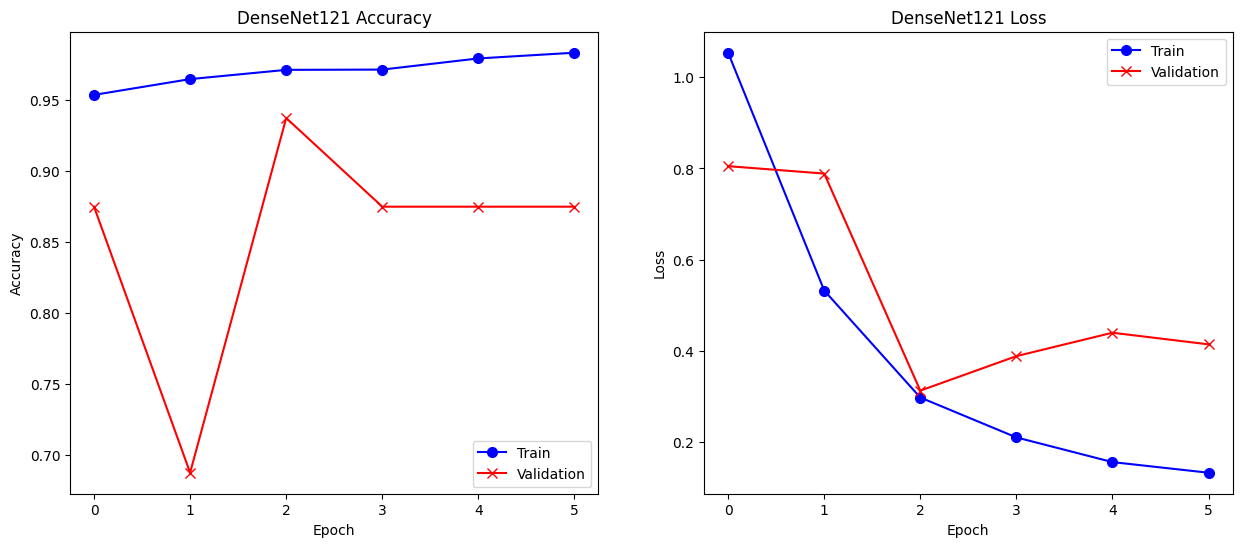

VGG16


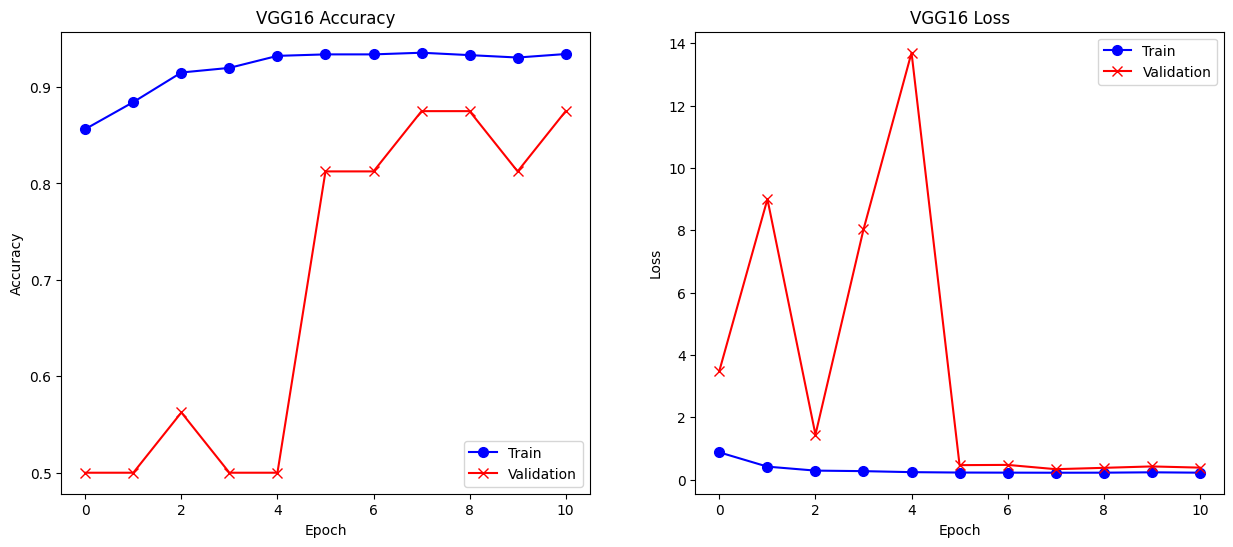

InceptionV3


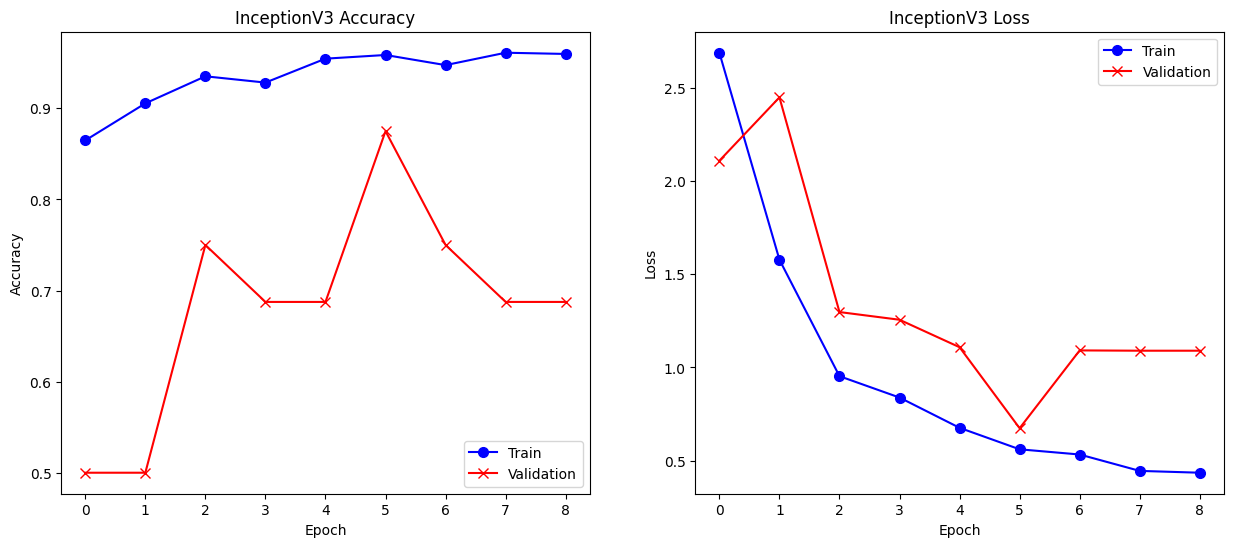

MobileNetV2


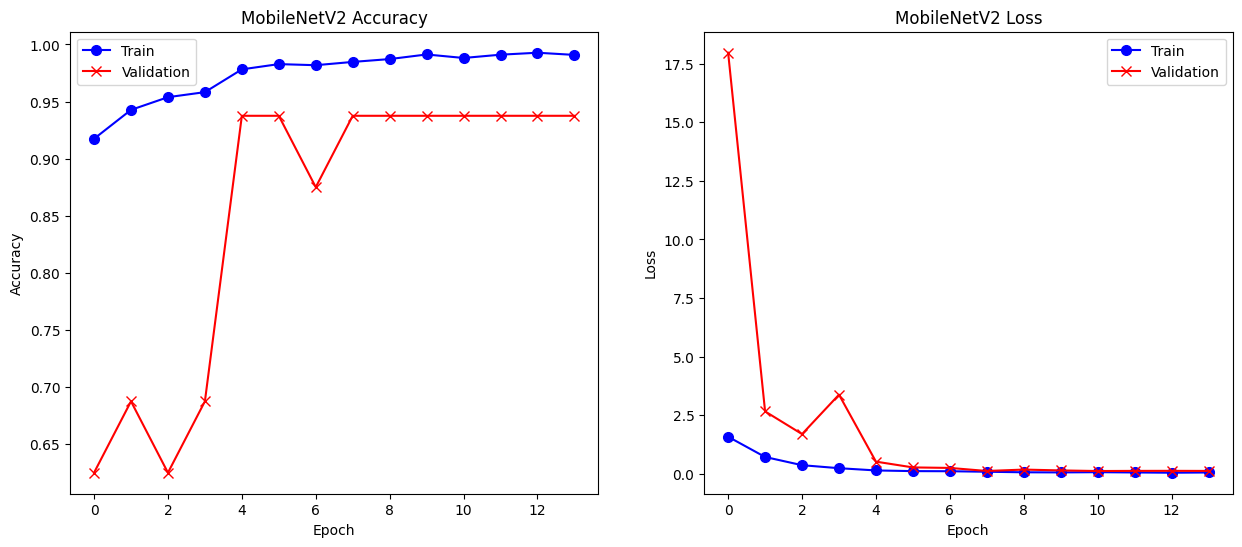

In [ ]:
# Plotting for DenseNet121
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy
ax[0].plot(history.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('DenseNet121 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# Loss
ax[1].plot(history.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('DenseNet121 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

print('DenseNet121')
plt.show()

# Plotting for VGG16
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy
ax[0].plot(history1.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history1.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('VGG16 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# Loss
ax[1].plot(history1.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history1.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('VGG16 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

print('VGG16')
plt.show()

# Plotting for InceptionV3
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy
ax[0].plot(history2.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history2.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('InceptionV3 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# Loss
ax[1].plot(history2.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history2.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('InceptionV3 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

print('InceptionV3')
plt.show()

# Plotting for MobileNetV2
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy
ax[0].plot(history3.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history3.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('MobileNetV2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# Loss
ax[1].plot(history3.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history3.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('MobileNetV2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

print('MobileNetV2')
plt.show()

DenseNet121


<Figure size 1000x1000 with 0 Axes>

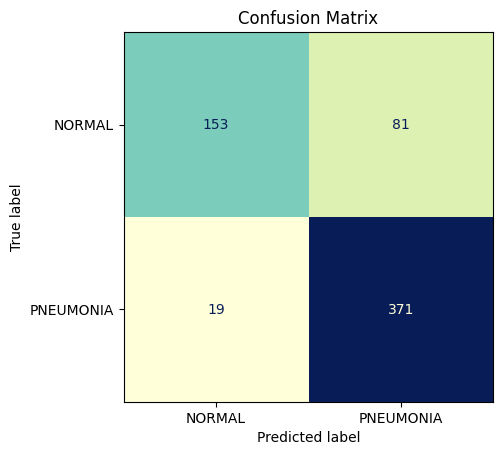

VGG16


<Figure size 1000x1000 with 0 Axes>

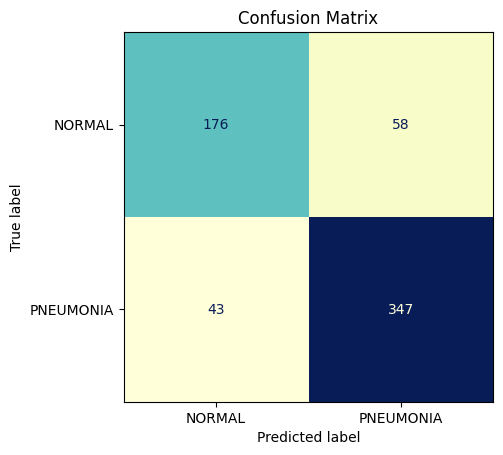

InceptionV3


<Figure size 1000x1000 with 0 Axes>

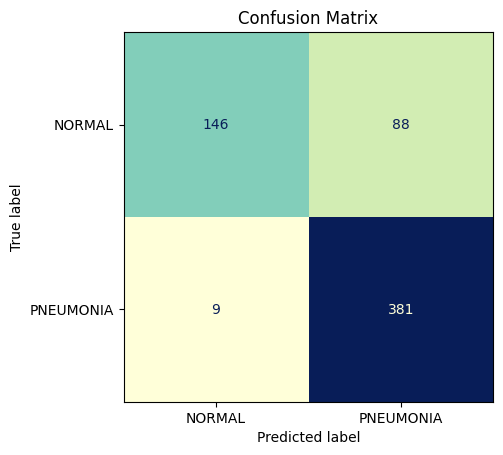

MobileNetV2


<Figure size 1000x1000 with 0 Axes>

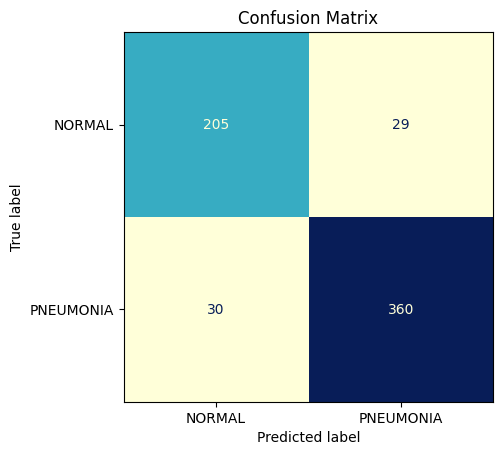

In [ ]:
test_matrix = confusion_matrix(test_classes, predicted_classes)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')
print('DenseNet121')
plt.show()

test_matrix = confusion_matrix(test_classes, predicted_classes1)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')
print('VGG16')
plt.show()

test_matrix = confusion_matrix(test_classes, predicted_classes2)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')
print('InceptionV3')
plt.show()

test_matrix = confusion_matrix(test_classes, predicted_classes3)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')
print('MobileNetV2')
plt.show()